# Abstractive Text Summmarization of Medical Data using Transformer-based Models
## Vedant Deshpande (A69032161)


## Importing libraries and loading dataset

In [2]:
!pip install datasets
!pip install evaluate

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, BartForConditionalGeneration, AutoTokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import evaluate

# Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# # Load Dataset and Sample Subset
# dataset = load_dataset("ccdv/pubmed-summarization", "section")
# train_df = pd.DataFrame(dataset['train']).sample(n=1000, random_state=42)
# test_df = pd.DataFrame(dataset['validation']).sample(n=200, random_state=42)

# # Rename columns for consistency
# train_df = train_df.rename(columns={"article": "transcription", "abstract": "summary"})
# test_df = test_df.rename(columns={"article": "transcription", "abstract": "summary"})

# Load dataset
dataset = load_dataset("ccdv/pubmed-summarization", "section")

# Convert to DataFrame
full_train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['validation']).sample(n=200, random_state=42)

# Split the training dataset into train and validation sets
train_df, val_df = train_test_split(full_train_df, test_size=0.2, random_state=42)

# Sample smaller subsets for experimentation (optional)
train_df = train_df.sample(n=1000, random_state=42)
val_df = val_df.sample(n=200, random_state=42)

# Rename columns for consistency
train_df = train_df.rename(columns={"article": "transcription", "abstract": "summary"})
val_df = val_df.rename(columns={"article": "transcription", "abstract": "summary"})
test_df = test_df.rename(columns={"article": "transcription", "abstract": "summary"})

# Dataset Class
class MedicalSummarizationDataset(Dataset):
    def __init__(self, dataframe, transcription_col, summary_col, tokenizer, input_len, output_len):
        self.dataframe = dataframe
        self.transcription_col = transcription_col
        self.summary_col = summary_col
        self.tokenizer = tokenizer
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        transcription = self.dataframe.iloc[idx][self.transcription_col]
        summary = self.dataframe.iloc[idx][self.summary_col]

        # Tokenize inputs and labels
        transcription_tokens = self.tokenizer(
            transcription, max_length=self.input_len, padding='max_length',
            truncation=True, return_tensors='pt'
        )['input_ids']

        summary_tokens = self.tokenizer(
            summary, max_length=self.output_len, padding='max_length',
            truncation=True, return_tensors='pt'
        )['input_ids']

        return transcription_tokens[0], summary_tokens[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train Dataset Shape: (119924, 2)
Validation Dataset Shape: (6633, 2)
Test Dataset Shape: (6658, 2)

Sample Data:
                                             article  \
0  a recent systematic analysis showed that in 20...   
1  it occurs in more than 50% of patients and may...   
2  tardive dystonia ( td ) , a rarer side effect ...   
3  lepidoptera include agricultural pests that , ...   
4  syncope is caused by transient diffuse cerebra...   

                                            abstract  
0  background : the present study was carried out...  
1  backgroundanemia in patients with cancer who a...  
2  tardive dystonia ( td ) is a serious side effe...  
3  many lepidopteran insects are agricultural pes...  
4  we present an unusual case of recurrent cough ...  

Missing Values:
article     0
abstract    0
dtype: int64


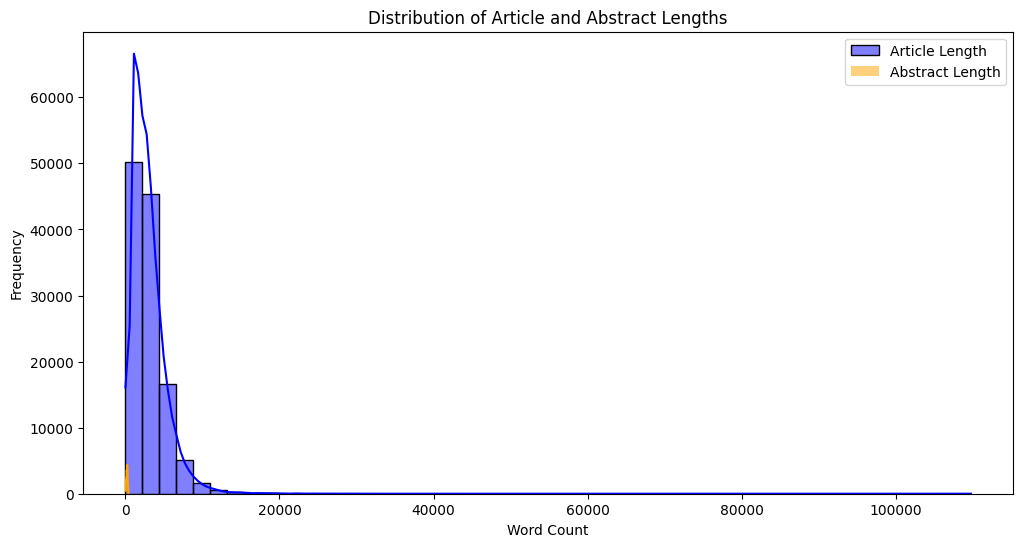

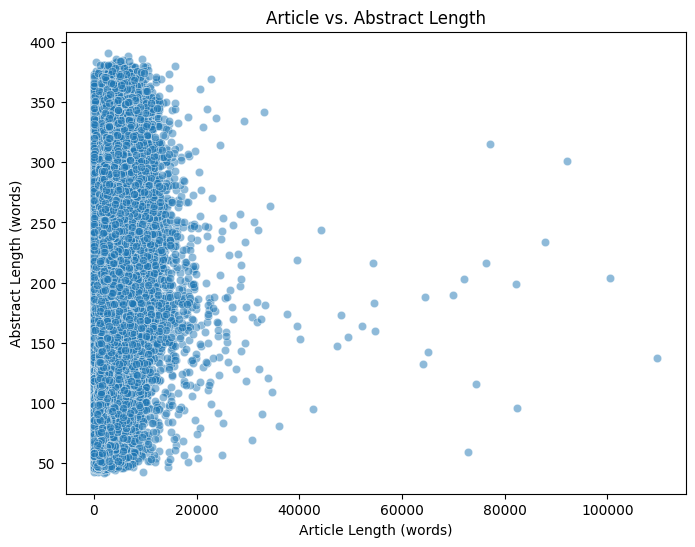


Statistical Summary of Text Lengths:
       article_length  abstract_length
count   119924.000000    119924.000000
mean      3044.244196       202.235407
std       2455.285555        78.226149
min          0.000000        42.000000
25%       1463.000000       142.000000
50%       2572.000000       208.000000
75%       3996.000000       262.000000
max     109759.000000       391.000000

Average, Min, and Max Lengths of Articles and Abstracts:
Average Article Length: 3044.24 words
Average Abstract Length: 202.24 words
Minimum Article Length: 0 words
Maximum Article Length: 109759 words
Minimum Abstract Length: 42 words
Maximum Abstract Length: 391 words


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DataFrame
train_df_eda = pd.DataFrame(dataset['train'])
val_df_eda = pd.DataFrame(dataset['validation'])
test_df_eda = pd.DataFrame(dataset['test'])

# Inspect Data
print("Train Dataset Shape:", train_df_eda.shape)
print("Validation Dataset Shape:", val_df_eda.shape)
print("Test Dataset Shape:", test_df_eda.shape)
print("\nSample Data:")
print(train_df_eda.head())

# Check for missing values
print("\nMissing Values:")
print(train_df_eda.isnull().sum())

# Distribution of article lengths
train_df_eda['article_length'] = train_df_eda['article'].apply(lambda x: len(x.split()))
train_df_eda['abstract_length'] = train_df_eda['abstract'].apply(lambda x: len(x.split()))

# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(train_df_eda['article_length'], kde=True, bins=50, color='blue', label='Article Length')
sns.histplot(train_df_eda['abstract_length'], kde=True, bins=50, color='orange', label='Abstract Length')
plt.title("Distribution of Article and Abstract Lengths")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Analyze correlation between article and abstract lengths
plt.figure(figsize=(8, 6))
sns.scatterplot(x='article_length', y='abstract_length', data=train_df_eda, alpha=0.5)
plt.title("Article vs. Abstract Length")
plt.xlabel("Article Length (words)")
plt.ylabel("Abstract Length (words)")
plt.show()

# Statistical summary
print("\nStatistical Summary of Text Lengths:")
print(train_df_eda[['article_length', 'abstract_length']].describe())

# Common words in articles and abstracts
# from collections import Counter
# from wordcloud import WordCloud

# # Function to generate word clouds
# def plot_wordcloud(text, title):
#     wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(text))
#     plt.figure(figsize=(10, 6))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(title, fontsize=16)
#     plt.show()

# # Generate word clouds
# plot_wordcloud(train_df_eda['article'], "Most Common Words in Articles")
# plot_wordcloud(train_df_eda['abstract'], "Most Common Words in Abstracts")

print("\nAverage, Min, and Max Lengths of Articles and Abstracts:")
article_lengths = train_df_eda['article_length']
abstract_lengths = train_df_eda['abstract_length']
print(f"Average Article Length: {article_lengths.mean():.2f} words")
print(f"Average Abstract Length: {abstract_lengths.mean():.2f} words")
print(f"Minimum Article Length: {article_lengths.min()} words")
print(f"Maximum Article Length: {article_lengths.max()} words")
print(f"Minimum Abstract Length: {abstract_lengths.min()} words")
print(f"Maximum Abstract Length: {abstract_lengths.max()} words")


## Baseline Model : google-t5/t5-small Model

In [15]:
t5_tokenizer = AutoTokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
t5_optimizer = torch.optim.Adam(t5_model.parameters(), lr=2e-5)

input_len = 1024
output_len = 200

def prepare_datasets(dataframe, tokenizer):
    return MedicalSummarizationDataset(dataframe, 'transcription', 'summary', tokenizer, input_len, output_len)

t5_train_dataset = prepare_datasets(train_df, t5_tokenizer)
t5_val_dataset = prepare_datasets(val_df, t5_tokenizer)
t5_test_dataset = prepare_datasets(test_df, t5_tokenizer)

batch_size = 2

t5_train_loader = DataLoader(t5_train_dataset, batch_size=batch_size, shuffle=True)
t5_val_loader = DataLoader(t5_val_dataset, batch_size=batch_size, shuffle=False)
t5_test_loader = DataLoader(t5_test_dataset, batch_size=batch_size, shuffle=False)


# Training and Evaluation Functions
def train_model(loader, model, optimizer, scaler, accumulation_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(inputs, labels=targets)
            loss = outputs.loss / accumulation_steps  # Divide loss for accumulation
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_model(loader, model):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, labels=targets)
            total_loss += outputs.loss.item()

    return total_loss / len(loader)

# Training Loop with Evaluation on Validation Data
epochs = 4
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    print("\nTraining T5:")
    t5_train_loss = train_model(t5_train_loader, t5_model, t5_optimizer, scaler)
    t5_eval_loss = evaluate_model(t5_val_loader, t5_model)
    print(f"T5 - Train Loss: {t5_train_loss:.4f}, Eval Loss: {t5_eval_loss:.4f}")


KeyboardInterrupt: 

## Initialize Tokenizers, Models and Optimizers

In [16]:
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
biobart_tokenizer = AutoTokenizer.from_pretrained("GanjinZero/biobart-base")
distilbart_tokenizer = AutoTokenizer.from_pretrained("Mahalingam/DistilBart-Med-Summary")

bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)
biobart_model = AutoModelForSeq2SeqLM.from_pretrained("GanjinZero/biobart-base").to(device)
distilbart_model = AutoModelForSeq2SeqLM.from_pretrained("Mahalingam/DistilBart-Med-Summary").to(device)

bart_optimizer = torch.optim.Adam(bart_model.parameters(), lr=2e-5)
biobart_optimizer = torch.optim.Adam(biobart_model.parameters(), lr=2e-5)
distilbart_optimizer = torch.optim.AdamW(distilbart_model.parameters(), lr=2e-5)
scaler = torch.cuda.amp.GradScaler()

!pip install rouge_score
rouge = evaluate.load("rouge")

def generate_and_evaluate(loader, model, tokenizer):
    model.eval()
    generated_summaries = []
    reference_summaries = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Generate summaries
            outputs = model.generate(inputs, max_length=output_len, num_beams=4, early_stopping=True)
            generated = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            references = tokenizer.batch_decode(targets, skip_special_tokens=True)

            generated_summaries.extend(generated)
            reference_summaries.extend(references)

    # Compute ROUGE scores
    results = rouge.compute(predictions=generated_summaries, references=reference_summaries, use_stemmer=True)

    return generated_summaries, reference_summaries, results

# Display Sample Results
def display_samples(generated, references, num_samples=3):
    for i in range(num_samples):
        print(f"\nSample {i + 1}:")
        print("Reference Summary:", references[i])
        print("Generated Summary:", generated[i])
        print("-" * 50)


print("\nEvaluating T5:")
t5_generated, t5_references, t5_rouge_scores = generate_and_evaluate(t5_loader, t5_model, t5_tokenizer)
print("T5 ROUGE Scores:", t5_rouge_scores)

print("\nT5 Generated Summaries:")
display_samples(t5_generated, t5_references)

<ipython-input-16-20c77e5a4b1d>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Initialize Tokenized Datasets and Dataloaders

In [17]:
# Training, Validation, Test Datasets
bart_train_dataset = prepare_datasets(train_df, bart_tokenizer)
bart_val_dataset = prepare_datasets(val_df, bart_tokenizer)
bart_test_dataset = prepare_datasets(test_df, bart_tokenizer)

biobart_train_dataset = prepare_datasets(train_df, biobart_tokenizer)
biobart_val_dataset = prepare_datasets(val_df, biobart_tokenizer)
biobart_test_dataset = prepare_datasets(test_df, biobart_tokenizer)

distilbart_train_dataset = prepare_datasets(train_df, distilbart_tokenizer)
distilbart_val_dataset = prepare_datasets(val_df, distilbart_tokenizer)
distilbart_test_dataset = prepare_datasets(test_df, distilbart_tokenizer)


bart_train_loader = DataLoader(bart_train_dataset, batch_size=batch_size, shuffle=True)
bart_val_loader = DataLoader(bart_val_dataset, batch_size=batch_size, shuffle=False)
bart_test_loader = DataLoader(bart_test_dataset, batch_size=batch_size, shuffle=False)


biobart_train_loader = DataLoader(biobart_train_dataset, batch_size=batch_size, shuffle=True)
biobart_val_loader = DataLoader(biobart_val_dataset, batch_size=batch_size, shuffle=False)
biobart_test_loader = DataLoader(biobart_test_dataset, batch_size=batch_size, shuffle=False)

distilbart_train_loader = DataLoader(distilbart_train_dataset, batch_size=batch_size, shuffle=True)
distilbart_val_loader = DataLoader(distilbart_val_dataset, batch_size=batch_size, shuffle=False)
distilbart_test_loader = DataLoader(distilbart_test_dataset, batch_size=batch_size, shuffle=False)

# Training and Evaluation Functions
def train_model(loader, model, optimizer, scaler, accumulation_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(inputs, labels=targets)
            loss = outputs.loss / accumulation_steps  # Divide loss for accumulation
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_model(loader, model):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, labels=targets)
            total_loss += outputs.loss.item()

    return total_loss / len(loader)

# Training Loop with Evaluation on Validation Data
epochs = 4
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    print("\nTraining BART:")
    bart_train_loss = train_model(bart_train_loader, bart_model, bart_optimizer, scaler)
    bart_eval_loss = evaluate_model(bart_val_loader, bart_model)
    print(f"BART - Train Loss: {bart_train_loss:.4f}, Eval Loss: {bart_eval_loss:.4f}")

    print("\nTraining BioBART:")
    biobart_train_loss = train_model(biobart_train_loader, biobart_model, biobart_optimizer, scaler)
    biobart_eval_loss = evaluate_model(biobart_val_loader, biobart_model)
    print(f"BioBART - Train Loss: {biobart_train_loss:.4f}, Eval Loss: {biobart_eval_loss:.4f}")

    print("\nTraining DistilBART:")
    distilbart_train_loss = train_model(distilbart_train_loader, distilbart_model, distilbart_optimizer, scaler)
    distilbart_eval_loss = evaluate_model(distilbart_val_loader, distilbart_model)
    print(f"DistilBART - Train Loss: {distilbart_train_loss:.4f}, Eval Loss: {distilbart_eval_loss:.4f}")



Epoch 1/4

Training T5:


<ipython-input-17-443b5e37f8f6>:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


T5 - Train Loss: 1.0699, Eval Loss: 3.2855

Training BART:
BART - Train Loss: 0.9368, Eval Loss: 2.5654

Training BioBART:
BioBART - Train Loss: 0.6322, Eval Loss: 1.9908

Training DistilBART:
DistilBART - Train Loss: 0.7627, Eval Loss: 2.3235

Epoch 2/4

Training T5:
T5 - Train Loss: 0.7940, Eval Loss: 3.0458

Training BART:
BART - Train Loss: 0.6879, Eval Loss: 2.3332

Training BioBART:
BioBART - Train Loss: 0.5182, Eval Loss: 1.9048

Training DistilBART:
DistilBART - Train Loss: 0.5829, Eval Loss: 2.2354

Epoch 3/4

Training T5:
T5 - Train Loss: 0.7508, Eval Loss: 2.9535

Training BART:
BART - Train Loss: 0.6264, Eval Loss: 2.2743

Training BioBART:
BioBART - Train Loss: 0.4803, Eval Loss: 1.8605

Training DistilBART:
DistilBART - Train Loss: 0.5281, Eval Loss: 2.2024

Epoch 4/4

Training T5:
T5 - Train Loss: 0.7250, Eval Loss: 2.8901

Training BART:
BART - Train Loss: 0.5966, Eval Loss: 2.2435

Training BioBART:
BioBART - Train Loss: 0.4531, Eval Loss: 1.8448

Training DistilBART:


## Evaluation Function

In [18]:
!pip install rouge_score
rouge = evaluate.load("rouge")

def get_results(is_test, bart_loader, biobart_loader, distilbart_loader):
    # Generate Summaries and Evaluate ROUGE
    if is_test: print("Evaluating Results on Test Data")
    else: print("Evaluating Results on Validation Data")
    def generate_and_evaluate(loader, model, tokenizer):
        model.eval()
        generated_summaries = []
        reference_summaries = []

        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Generate summaries
                outputs = model.generate(inputs, max_length=output_len, num_beams=4, early_stopping=True)
                generated = tokenizer.batch_decode(outputs, skip_special_tokens=True)
                references = tokenizer.batch_decode(targets, skip_special_tokens=True)

                generated_summaries.extend(generated)
                reference_summaries.extend(references)

        # Compute ROUGE scores
        results = rouge.compute(predictions=generated_summaries, references=reference_summaries, use_stemmer=True)

        return generated_summaries, reference_summaries, results

    # Display Sample Results
    def display_samples(generated, references, num_samples=3):
        for i in range(num_samples):
            print(f"\nSample {i + 1}:")
            print("Reference Summary:", references[i])
            print("Generated Summary:", generated[i])
            print("-" * 50)



    print("\nEvaluating T5:")
    t5_generated, t5_references, t5_rouge_scores = generate_and_evaluate(t5_loader, t5_model, t5_tokenizer)
    print("T5 ROUGE Scores:", t5_rouge_scores)

    print("\nT5 Generated Summaries:")
    display_samples(t5_generated, t5_references)




    print("\nEvaluating BART:")
    bart_generated, bart_references, bart_rouge_scores = generate_and_evaluate(bart_loader, bart_model, bart_tokenizer)
    print("BART ROUGE Scores:", bart_rouge_scores)

    print("\nBART Generated Summaries:")
    display_samples(bart_generated, bart_references)




    print("\nEvaluating BioBART:")
    biobart_generated, biobart_references, bart_rouge_scores = generate_and_evaluate(biobart_loader, biobart_model, bart_tokenizer)
    print("BioBART ROUGE Scores:", bart_rouge_scores)

    print("\nBioBART Generated Summaries:")
    display_samples(bart_generated, bart_references)



    print("\nEvaluating DistilBART:")
    distilbart_generated, distilbart_references, t5_rouge_scores = generate_and_evaluate(distilbart_loader, distilbart_model, t5_tokenizer)
    print("DistilBART ROUGE Scores:", t5_rouge_scores)

    print("\nDistilBART Generated Summaries:")
    display_samples(t5_generated, t5_references)

## Validation Results

In [19]:
# passing is_test as False
get_results(False, bart_val_loader, biobart_val_loader, distilbart_val_loader)

Evaluating Results on Validation Data

Evaluating T5:
T5 ROUGE Scores: {'rouge1': 0.2680064497562724, 'rouge2': 0.07959900552119048, 'rougeL': 0.1669800309535329, 'rougeLsum': 0.16719951202232286}

T5 Generated Summaries:

Sample 1:
Reference Summary: the proliferation of vascular smooth muscle cells ( vsmcs ) is one of the main features of atherosclerosis induced by high glucose. mevalonate pathway is an important metabolic pathway that plays a key role in multiple cellular processes. the aim of this study was to define whether the enzyme expression in mevalonate pathway is changed in proliferated vsmcs during atherogenic process in diabetic mice. diabetes was induced in balb / c mice with streptozotocin ( stz, 50 mg / kg / day for 5 days ). induction of diabetes with stz was associated with an increase of lesion area and media thickness after 8 and 16 weeks of diabetes. in aorta, there were overexpressions of some enzymes, including 3-hydroxy-3-methylglutaryl 
Generated Summary: vsmc

## Test Results

In [20]:
# Passing is_test as True and Test Loaders for the models
get_results(True, bart_test_loader, biobart_test_loader, distilbart_test_loader)

Evaluating Results on Test Data

Evaluating T5:
T5 ROUGE Scores: {'rouge1': 0.29297914942301867, 'rouge2': 0.09600384802350329, 'rougeL': 0.18075222740508481, 'rougeLsum': 0.18095162471488396}

T5 Generated Summaries:

Sample 1:
Reference Summary: ionized hypocalcemia is a common finding in critically ill patients, but the relationship between ionized hypocalcemia and mortality risk in trauma patients has not been well established. the aim of this study was to assess the usefulness of initial ionized calcium ( ica ) in predicting mortality in the trauma population, and evaluate its superiority over the three other triage tools : base deficit, systemic inflammatory response syndrome ( sirs ) score, and triage - revised trauma score ( t - rts ). a proand retrospective study was performed on 255 consecutive trauma patients admitted to our emergency medical center from january to december, 2005, who underwent arterial blood gas analysis. multivariate logistic regression analysis confirmed 